## Parameter and Module

In [35]:
from dataclasses import dataclass
from typing import List
import numpy as np


@dataclass
class Parameter:
    name: str
    data: np.ndarray
    grad: np.ndarray


class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def backward(self, *args, **kwargs):
        raise NotImplementedError
    
    def parameters(self) -> List[Parameter]:
        return []
    
    def zero_grad(self):
        for param in self.parameters():
            param.grad.fill(0)

## Weights initialization

In [36]:
import numpy as np
from typing import Literal

# Define a custom type alias for initialization methods
InitMethod = Literal["xavier", "he", "he_leaky", "normal", "uniform"]

def parameter(
    input_size: int,
    output_size: int,
    init_method: InitMethod = "xavier",
    gain: float = 1,
    alpha: float = 0.01
) -> np.ndarray:
    weights = np.random.randn(input_size, output_size)

    if init_method == "xavier":
        std = gain * np.sqrt(1.0 / input_size)
        return std * weights
    if init_method == "he":
        std = gain * np.sqrt(2.0 / input_size)
        return std * weights
    if init_method == "he_leaky":
        std = gain * np.sqrt(2.0 / (1 + alpha**2) * (1 / input_size))
        return std * weights
    if init_method == "normal":
        return gain * weights
    if init_method == "uniform":
        return gain * np.random.uniform(-1, 1, size=(input_size, output_size))

    raise ValueError(f"Unknown initialization method: {init_method}")

## Series of Transformations

$$f(\mathbf{x}) = \sigma(A_L(\sigma(A_{L-1}( \dots \sigma(A_1(\mathbf{x})) \dots ))).$$

## Functional composition

$$f(\mathbf{x}) = A_L \circ \sigma \circ A_{L-1} \circ \dots \circ \sigma \circ A_1 (\mathbf{x})$$

## Linear Layer 

$$A_i(\mathbf{x}) = \mathbf{x}\mathbf{w}_i + b_i$$

**Backward**

$$\nabla A_i(\mathbf{x}) = \begin{bmatrix}
\frac{\partial A_i(\mathbf{x})}{\partial \mathbf{w_i}} \\
\frac{\partial A_i(\mathbf{x})}{\partial \mathbf{b_i}}
\end{bmatrix} =
\begin{bmatrix}
\mathbf{x}^T \\
1
\end{bmatrix}$$

Chain rule: 


$$\begin{bmatrix}
\mathbf{x}^T \\
1
\end{bmatrix} \cdot d_{\text{out}}$$


In [37]:
class Linear(Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        init_method: InitMethod = "xavier"
    ):
        self.input: np.ndarray = None

        self.weights: np.ndarray = parameter(input_size, output_size, init_method)
        self.d_weights: np.ndarray = np.zeros_like(self.weights)

        self.biases: np.ndarray = np.zeros((1, output_size))
        self.d_biases: np.ndarray = np.zeros_like(self.biases)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        x1 = x @ self.weights + self.biases
        return x1
    
    def backward(self, d_out: np.ndarray) -> np.ndarray:
        self.d_weights = self.input.T @ d_out
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)

        return d_out @ self.weights.T

    def parameters(self):
        return [
            Parameter(
                name="weights",
                data=self.weights,
                grad=self.d_weights
            ),
            Parameter(
                name="biases",
                data=self.biases,
                grad=self.d_biases
            ),
        ]

## Binary Cross-Entropy Loss

In [38]:
class BCELoss(Module):
    def forward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:        
        loss = -(
            target * np.log(pred + epsilon) + 
            (1 - target) * np.log(1 - pred + epsilon)
        )

        return np.mean(loss)

    def backward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:
        grad = (pred - target) / (pred * (1 - pred) + epsilon)
        return grad

## Sigmoid

In [39]:
class Sigmoid(Module):
    def forward(self, x: np.ndarray):
        # Apply the Sigmoid function element-wise
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, d_out: np.ndarray):
        # Derivative of the Sigmoid function: sigmoid * (1 - sigmoid)
        ds = self.output * (1 - self.output)
        return d_out * ds

## Stochastic Gradient Descent (SGD)

Momentum:

$$v_{t+1} = \mu \cdot v_{t} - \alpha \nabla f(x_t)$$

The update rule for our position becomes:

$$x_{t+1} = x_t + v_{t+1}$$

In [40]:
class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.0
    ):
        self.lr = lr
        self.momentum = momentum
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Update momentum
            self.velocity[param_id] = self.momentum * self.velocity[param_id] - self.lr * grad

            # Update parameters
            param.data += self.velocity[param_id]

## Training

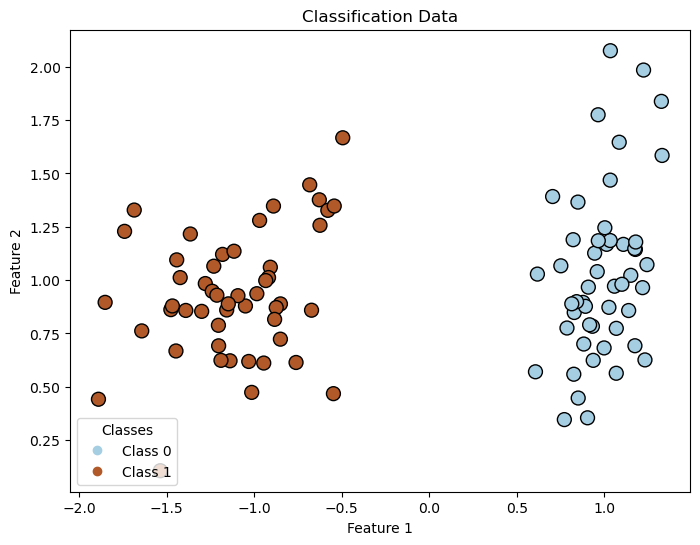

In [41]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


# Default params
n_samples = 100
features = 2

# Create random input data
x, y_target = make_classification(
    n_samples=n_samples,
    n_features=features,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0,
    random_state=1
)
y_target = y_target.reshape(-1, 1)


# Plot the data
plt.figure(figsize=(8, 6))

# Create scatter plot
scatter = plt.scatter(
    x[:, 0],
    x[:, 1],
    c=y_target.flatten(), 
    cmap=plt.cm.Paired, 
    edgecolor='k', 
    s=100,
)

# Title and labels
plt.title("Classification Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Add color legend using scatter's 'c' values
handles, labels = scatter.legend_elements()

# Modify labels to add custom class names
custom_labels = ['Class 0', 'Class 1']  # Custom labels for each class

# Use the custom labels in the legend
plt.legend(handles, custom_labels, title="Classes", loc="lower left")

plt.show()

In [42]:
model = Linear(input_size=features, output_size=1, init_method="xavier")
activation = Sigmoid()
bce = BCELoss()
optimizer = SGD(lr=0.01, momentum=0.9)

## Training loop

In [43]:
n_epoch = 10

for epoch in range(n_epoch):
    # Forward
    output = model(x)
    y_pred = activation(output)
    loss = bce(y_pred, y_target)

    model.zero_grad()

    # Backward
    grad = bce.backward(y_pred, y_target)
    grad = activation.backward(grad)
    model.backward(grad)

    optimizer.step(model)

    print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.8118
Epoch 1, Loss: 0.5165
Epoch 2, Loss: 0.2331
Epoch 3, Loss: 0.0948
Epoch 4, Loss: 0.0408
Epoch 5, Loss: 0.0194
Epoch 6, Loss: 0.0101
Epoch 7, Loss: 0.0058
Epoch 8, Loss: 0.0035
Epoch 9, Loss: 0.0023


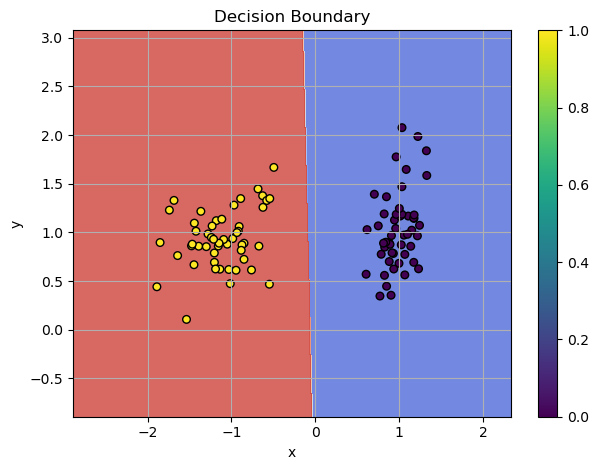

In [44]:
# Define function for plotting decision boundaries
def plot_decision_boundaries(model, X, y, bins=500):
    # Set the limits of the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, bins), np.linspace(y_min, y_max, bins))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get the predicted class for each point in the grid
    Z = model.forward(grid)  # Only get the predicted output
    Z = (Z > 0.5).astype(int)  # Assuming binary classification

    # Reshape the predictions back to the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', marker='o', s=30, label='Data Points')
    plt.title('Decision Boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


plot_decision_boundaries(model, x, y_target)